# Stock Feature Pipeline

This notebook is divided into following sections:

1. Getting Data from API and Converting it into a Dataset


In [11]:
# Import the required libraries and load in the environment variables
import hopsworks
import os
from dotenv import load_dotenv

import requests
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

plt.style.use('grayscale')

# Load the .env file
load_dotenv()

# Get the environment variables
tiingo_api_key = os.getenv("TIINGO_API_KEY")
hopsworks_api_key = os.getenv("HOPSWORKS_API_KEY")

### Getting Data From API


#### Generate Dataset from API getting last year data


In [ ]:

def create_dataset_chunk(start_date: str, end_date: str, ticker="AMZN", freq: str = '60min') -> pd.DataFrame:

    # Format the url with start_data, end_data and freq
    url = f"https://api.tiingo.com/iex/{ticker}/prices?startDate={start_date}&endDate={end_date}&resampleFreq={freq}&token={tiingo_api_key}"
    response = requests.get(url).json()

    return pd.DataFrame(response)


# df = create_dataset_chunk("2024-01-01", "2024-02-29")  # Test the function

In [16]:
df = create_dataset_chunk('2023', '2024')

In [17]:
df.head()

,date,close,high,low,open
0,2023-02-21T15:00:00.000Z,94.515,95.23,94.355,95.090
1,2023-02-21T16:00:00.000Z,94.410,94.74,94.370,94.515
2,2023-02-21T17:00:00.000Z,94.590,94.75,94.280,94.420
3,2023-02-21T18:00:00.000Z,94.525,94.63,94.365,94.590
4,2023-02-21T19:00:00.000Z,94.865,94.94,94.295,94.535


In [18]:
df.tail()

,date,close,high,low,open
1549,2024-02-16T16:00:00.000Z,170.000,170.415,168.930,169.030
1550,2024-02-16T17:00:00.000Z,169.675,170.125,169.405,169.995
1551,2024-02-16T18:00:00.000Z,170.145,170.160,169.420,169.670
1552,2024-02-16T19:00:00.000Z,169.400,170.400,169.160,170.145
1553,2024-02-16T20:00:00.000Z,169.490,170.035,169.230,169.415


The API limits data retrieval to a maximum of 2 months at a time. Therefore, data must be fetched in 2-month intervals and then merged into a single dataset.


In [ ]:
years = [2019, 2020, 2021, 2022, 2023, 2024]

for i in range(len(years) - 1):
    print(years[i], years[i + 1])

2020 2021
2021 2022
2022 2023
2023 2024


In [28]:

def create_supervised_dataset(years: list, ticker: str = "AMZN", freq: str = '60min') -> pd.DataFrame:
    """
    Generates a supervised dataset from DataFrame chunks based on the provided date ranges.

    Args:
        dates (dict): A dictionary where keys are start dates and values are end dates.
        ticker (str): The stock ticker symbol. Default is "AMZN".
        freq (str): The frequency of the data. Default is '60min'.

    Returns:
        pd.DataFrame: A DataFrame containing the concatenated data for all date ranges.
    """
    # Initialize an empty DataFrame to store the concatenated data
    data = pd.DataFrame()

    # Iterate over each date range in the dates dictionary
    for i in tqdm(range(len(years) - 1)):
        # Create a DataFrame chunk for the given date range, ticker, and frequency
        df = create_dataset_chunk(
            start_date=f"{years[i]}-01-01", end_date=f"{years[i+1]}-12-31")

        # Concatenate the new chunk with the existing data
        data = pd.concat([data, df])

        # Get the current year stock market data
    data = pd.concat([data, create_dataset_chunk('2025-01-01', '2025-02-18')])

    # Change the date column to datetime format
    data['date'] = data['date'].map(lambda x: x.split('.')[0])
    data['date'] = pd.to_datetime(data['date'])

    # Set the index as the date column
    data = data.set_index("date")
    # Return the concatenated DataFrame
    return data.sort_index()

In [29]:
# Call the function
data = create_supervised_dataset(years)

print(data.head())

100%|██████████| 4/4 [00:59<00:00, 14.95s/it]


                        close      high       low      open
date                                                       
2020-01-02 15:00:00  1870.510  1875.210  1864.690  1873.875
2020-01-02 16:00:00  1872.455  1873.660  1866.455  1870.605
2020-01-02 17:00:00  1877.330  1878.680  1870.345  1872.455
2020-01-02 18:00:00  1880.690  1881.205  1876.055  1877.110
2020-01-02 19:00:00  1895.210  1897.070  1880.690  1880.690


In [32]:
data.head()

,close,high,low,open
date,,,,
2020-01-02 15:00:00,1870.510,1875.210,1864.690,1873.875
2020-01-02 16:00:00,1872.455,1873.660,1866.455,1870.605
2020-01-02 17:00:00,1877.330,1878.680,1870.345,1872.455
2020-01-02 18:00:00,1880.690,1881.205,1876.055,1877.110
2020-01-02 19:00:00,1895.210,1897.070,1880.690,1880.690


In [33]:
data.tail()

,close,high,low,open
date,,,,
2025-02-18 16:00:00,224.360,225.605,224.245,225.550
2025-02-18 17:00:00,225.020,225.050,223.840,224.360
2025-02-18 18:00:00,224.275,225.245,223.740,225.025
2025-02-18 19:00:00,224.510,224.690,223.750,224.275
2025-02-18 20:00:00,226.640,226.640,224.270,224.515


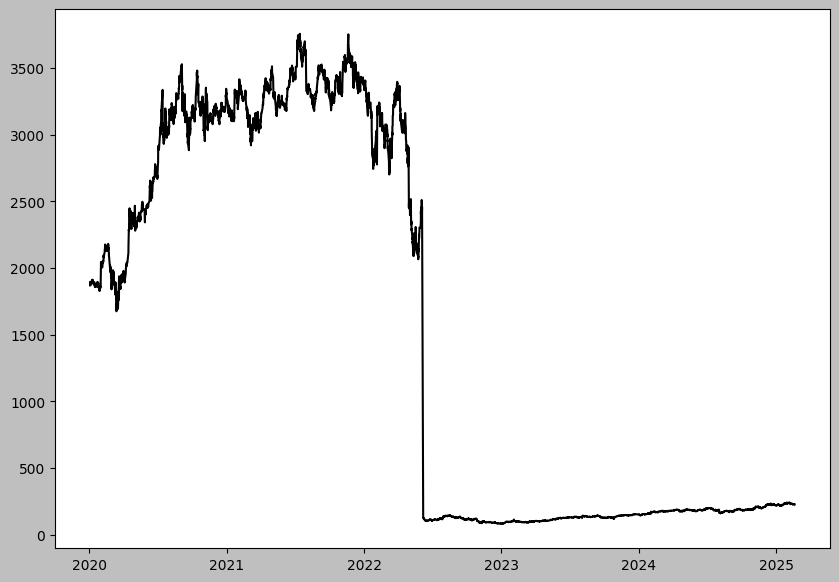

In [34]:

plt.figure(figsize=(10, 7))
plt.plot(data.index, data["close"])
plt.show()

### Generate
